In [9]:
# Importar librerías
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Preparación del entorno
Definición de variables y funciones para la descarga y visualización de los datos a través de la librería y preparar el dataset.

In [10]:
# Definir los símbolos y el periodo
simbolos = ["IBM", "WMT"]
periodo = "5y"  # últimos 5 años

In [11]:
# Descargar datos individuales
datos_historicos = {}
for simbolo in simbolos:
    ticker = yf.Ticker(simbolo)
    historial = ticker.history(period=periodo)
    datos_historicos[simbolo] = historial

In [12]:
# Revisar las columnas existentes
for simbolo, df in datos_historicos.items():
    print(f"Columnas disponibles para {simbolo}:")
    print(df.columns)
    print("\n")

Columnas disponibles para IBM:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


Columnas disponibles para WMT:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')




In [13]:
# Construir el DataFrame conjunto
adj = pd.concat([
    datos_historicos["IBM"]["Close"].rename("IBM"),
    datos_historicos["WMT"]["Close"].rename("WMT")
], axis=1)

# Limpiar valores faltantes
adj = adj.dropna()

# Revisar las primeras filas
print(adj.head())


                                 IBM        WMT
Date                                           
2020-08-17 00:00:00-04:00  95.867531  42.260975
2020-08-18 00:00:00-04:00  96.237297  41.983597
2020-08-19 00:00:00-04:00  95.405304  41.266781
2020-08-20 00:00:00-04:00  94.873711  40.693333
2020-08-21 00:00:00-04:00  94.881424  41.023693


# Graficar las series y ver tendencias

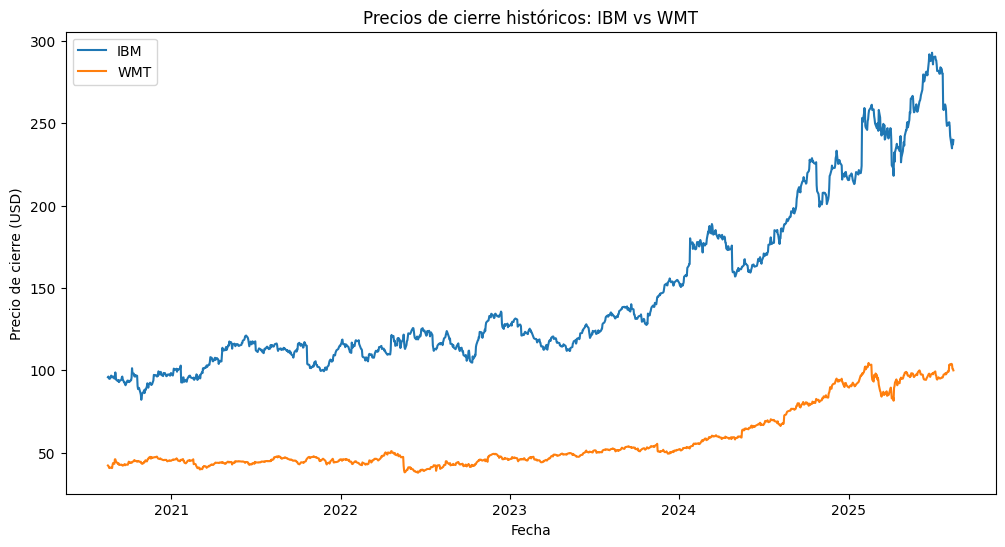

In [14]:
# Graficar las series
plt.figure(figsize=(12,6))
plt.plot(adj.index, adj["IBM"], label="IBM")
plt.plot(adj.index, adj["WMT"], label="WMT")
plt.title("Precios de cierre históricos: IBM vs WMT")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.legend()
plt.show()

# Calcular la correlación

In [15]:
# Matriz de correlación
corr = adj.corr()
print("Correlación entre IBM y WMT:")
print(corr)

Correlación entre IBM y WMT:
          IBM       WMT
IBM  1.000000  0.959104
WMT  0.959104  1.000000



--- Análisis para IBM ---


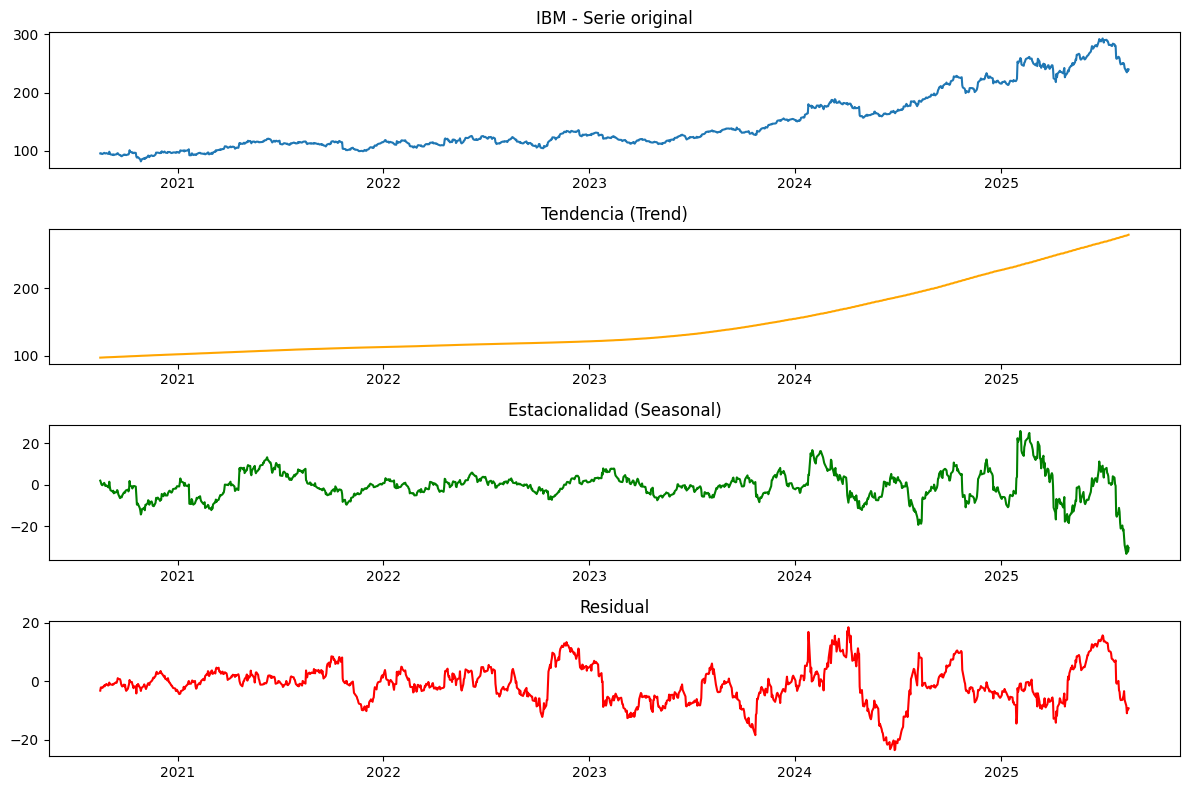

<Figure size 1200x500 with 0 Axes>

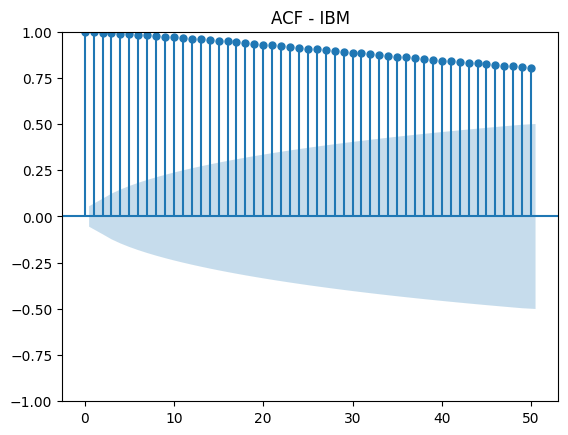

<Figure size 1200x500 with 0 Axes>

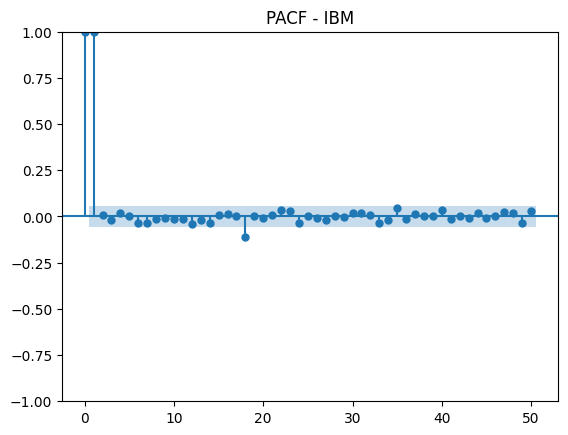


--- Análisis para WMT ---


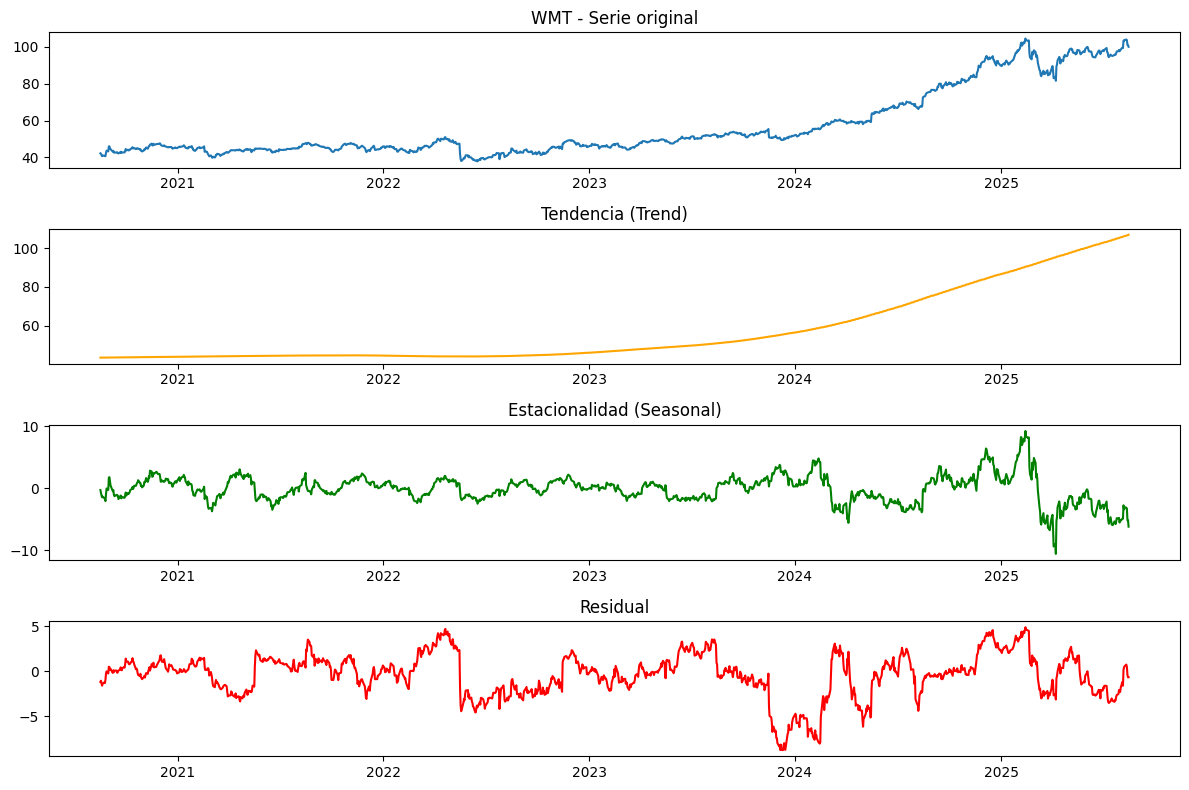

<Figure size 1200x500 with 0 Axes>

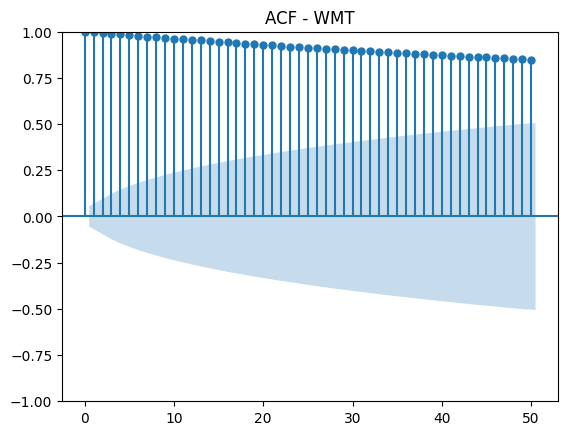

<Figure size 1200x500 with 0 Axes>

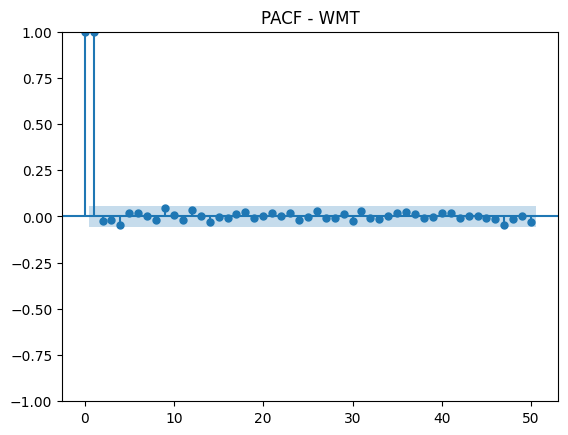

In [16]:
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Función para descomposición y correlogramas
def analizar_serie(df, columna, freq=252):  # freq=252 asumiendo días hábiles en un año
    print(f"\n--- Análisis para {columna} ---")

    # Descomposición STL
    stl = STL(df[columna], period=freq)
    result = stl.fit()

    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid

    # Graficar componentes
    plt.figure(figsize=(12,8))

    plt.subplot(4,1,1)
    plt.plot(df.index, df[columna], label="Original")
    plt.title(f"{columna} - Serie original")

    plt.subplot(4,1,2)
    plt.plot(df.index, trend, label="Trend", color="orange")
    plt.title("Tendencia (Trend)")

    plt.subplot(4,1,3)
    plt.plot(df.index, seasonal, label="Seasonal", color="green")
    plt.title("Estacionalidad (Seasonal)")

    plt.subplot(4,1,4)
    plt.plot(df.index, resid, label="Residual", color="red")
    plt.title("Residual")

    plt.tight_layout()
    plt.show()

    # Correlogramas
    plt.figure(figsize=(12,5))
    plot_acf(df[columna], lags=50, title=f"ACF - {columna}")
    plt.show()

    plt.figure(figsize=(12,5))
    plot_pacf(df[columna], lags=50, title=f"PACF - {columna}")
    plt.show()

# Aplicar a ambas series
analizar_serie(adj, "IBM")
analizar_serie(adj, "WMT")


# Prueba de Dickey-Fuller aumentada (ADF)

In [17]:
from statsmodels.tsa.stattools import adfuller

# Función para ADF
def prueba_adf(df, columna):
    print(f"\n--- Prueba Dickey-Fuller para {columna} ---")
    resultado = adfuller(df[columna])
    print(f"ADF Statistic: {resultado[0]:.4f}")
    print(f"p-value: {resultado[1]:.4f}")
    print(f"# Lags utilizados: {resultado[2]}")
    print(f"# Observaciones usadas: {resultado[3]}")
    print("Valores críticos:")
    for key, value in resultado[4].items():
        print(f"   {key}: {value:.4f}")

    if resultado[1] < 0.05:
        print("→ La serie es estacionaria (rechazamos H0)")
    else:
        print("→ La serie NO es estacionaria (no rechazamos H0)")

# Aplicar a ambas series
prueba_adf(adj, "IBM")
prueba_adf(adj, "WMT")


--- Prueba Dickey-Fuller para IBM ---
ADF Statistic: -0.1944
p-value: 0.9392
# Lags utilizados: 0
# Observaciones usadas: 1255
Valores críticos:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680
→ La serie NO es estacionaria (no rechazamos H0)

--- Prueba Dickey-Fuller para WMT ---
ADF Statistic: 1.0250
p-value: 0.9945
# Lags utilizados: 22
# Observaciones usadas: 1233
Valores críticos:
   1%: -3.4357
   5%: -2.8639
   10%: -2.5680
→ La serie NO es estacionaria (no rechazamos H0)


# promedios móviles simples (SMA)
Se realiza el pronóstico de 1 día para IBM y Walmart.

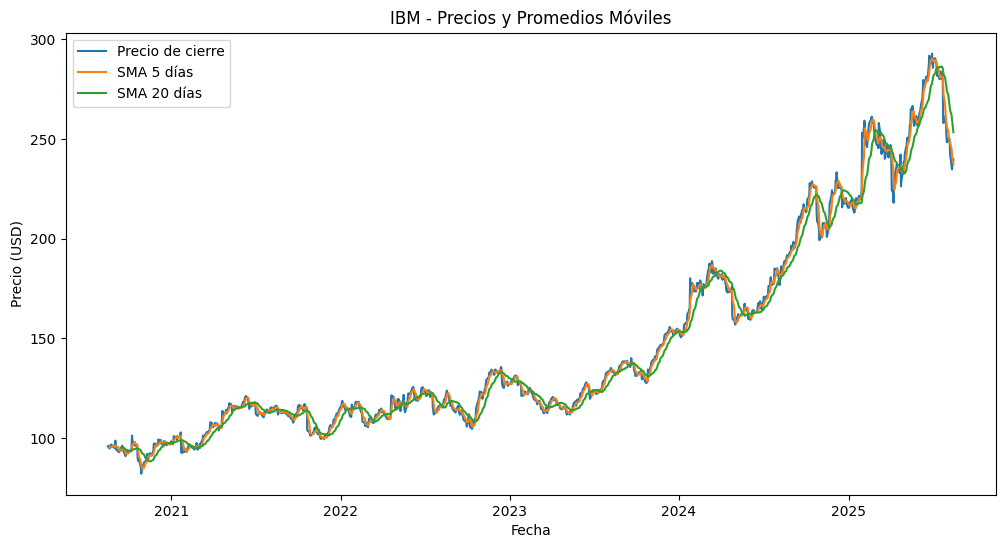

Pronóstico simple de cierre siguiente día para IBM: 253.44 USD


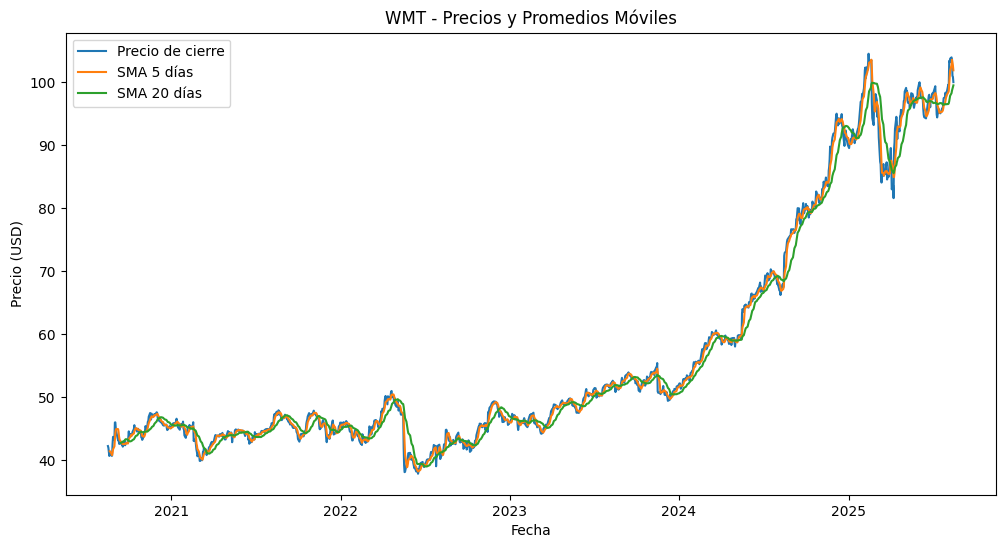

Pronóstico simple de cierre siguiente día para WMT: 99.49 USD


In [18]:
# Definir ventanas de promedios móviles
ventanas = [5, 20]  # 5 días y 20 días

# Calcular y graficar para cada serie
for columna in ["IBM", "WMT"]:
    plt.figure(figsize=(12,6))
    plt.plot(adj.index, adj[columna], label="Precio de cierre")

    for window in ventanas:
        adj[f"SMA_{window}_{columna}"] = adj[columna].rolling(window=window).mean()
        plt.plot(adj.index, adj[f"SMA_{window}_{columna}"], label=f"SMA {window} días")

    plt.title(f"{columna} - Precios y Promedios Móviles")
    plt.xlabel("Fecha")
    plt.ylabel("Precio (USD)")
    plt.legend()
    plt.show()

    # Pronóstico simple: siguiente día = último promedio móvil
    ultimo_sma = adj[f"SMA_{ventanas[-1]}_{columna}"].iloc[-1]
    print(f"Pronóstico simple de cierre siguiente día para {columna}: {ultimo_sma:.2f} USD")

# Backtest simple usando SMA de 20 días


--- Backtest SMA 20 días para IBM ---
MAE: 5.12 USD
MAPE: 3.29%


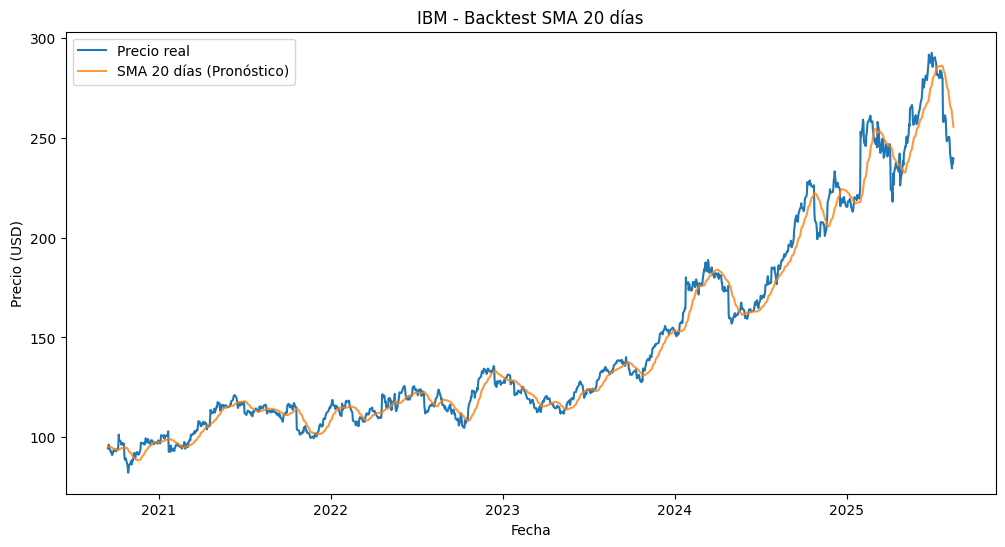


--- Backtest SMA 20 días para WMT ---
MAE: 1.61 USD
MAPE: 2.71%


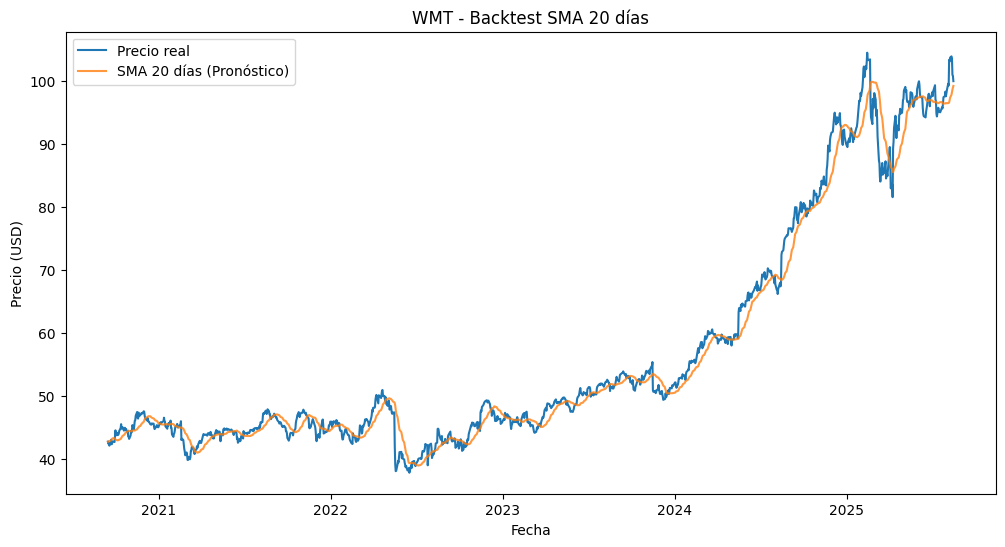

In [19]:
import numpy as np

# Función de backtest SMA
def backtest_sma(df, columna, window=20):
    sma = df[columna].rolling(window=window).mean().shift(1)  # SMA del día anterior como pronóstico
    actual = df[columna]

    # Eliminar primeros 'window' días
    valid = ~sma.isna()
    sma = sma[valid]
    actual = actual[valid]

    # Calcular errores
    mae = np.mean(np.abs(actual - sma))
    mape = np.mean(np.abs((actual - sma)/actual)) * 100

    print(f"\n--- Backtest SMA {window} días para {columna} ---")
    print(f"MAE: {mae:.2f} USD")
    print(f"MAPE: {mape:.2f}%")

    # Graficar pronóstico vs real
    plt.figure(figsize=(12,6))
    plt.plot(actual.index, actual, label="Precio real")
    plt.plot(sma.index, sma, label=f"SMA {window} días (Pronóstico)", alpha=0.8)
    plt.title(f"{columna} - Backtest SMA {window} días")
    plt.xlabel("Fecha")
    plt.ylabel("Precio (USD)")
    plt.legend()
    plt.show()

# Aplicar backtest a IBM y WMT
backtest_sma(adj, "IBM", window=20)
backtest_sma(adj, "WMT", window=20)